In [278]:
# *************** This module classifies tweet text ****************
# ******************* into categories such environment, social and governance ******************

## All purpose library
import pandas as pd
import numpy as np

## NLP library
import re
import string
import nltk
from nltk.corpus import stopwords
from langdetect import detect

## ML Library
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import RepeatedStratifiedKFold,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline 
import pickle
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC 
from sklearn.semi_supervised import LabelPropagation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score

#Sentence Transformers
import tensorflow as tf
import tensorflow_hub as hub
from sentence_transformers import SentenceTransformer


## Visualization library
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud 

In [2]:
df=  pd.read_csv('../data/influencer/RL2013D02E055_tweet_texts.csv')
len(df)

1253

# Exploratory Data Analysis

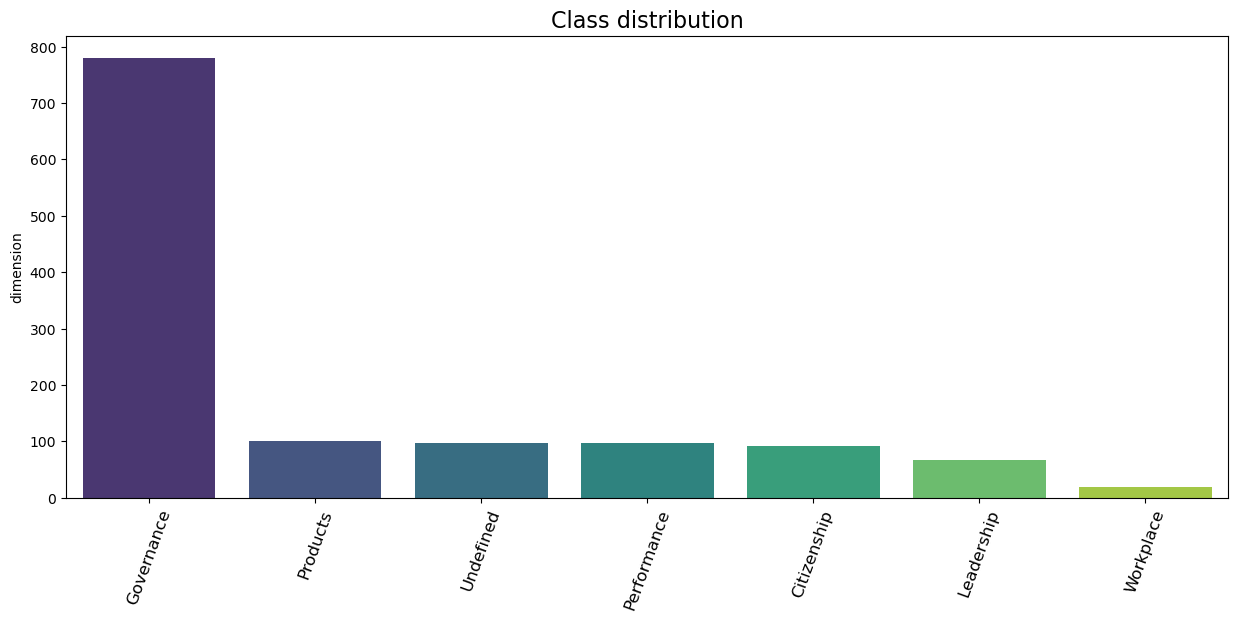

In [3]:
common_keywords=df["dimension"].value_counts()[:20].to_frame()

fig=plt.figure(figsize=(15,6))
sns.barplot(data=common_keywords, x=common_keywords.index, y="dimension", palette="viridis")
plt.title("Class distribution", size=16)
plt.xticks(rotation=70, size=12);
plt.show()

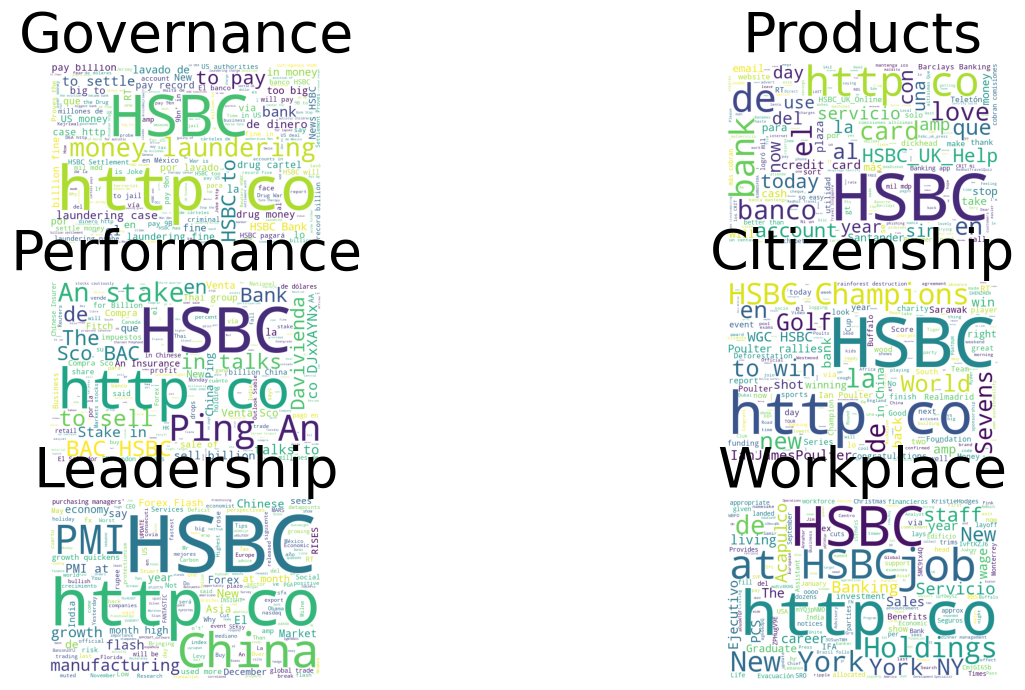

In [4]:
def plot_word_clouds(df):
    
    g_tweets = df[df['dimension']=='Governance']['tweet_text']
    p_tweets = df[df['dimension']=='Products']['tweet_text']
    pe_tweets = df[df['dimension']=='Performance']['tweet_text']
    c_tweets = df[df['dimension']=='Citizenship']['tweet_text']
    l_tweets = df[df['dimension']=='Leadership']['tweet_text']
    w_tweets = df[df['dimension']=='Workplace']['tweet_text']

    fig, ax = plt.subplots(3, 2, figsize=[16, 8])

    wordcloud1 = WordCloud( background_color='white',
                            width=600,
                            height=400).generate(" ".join(g_tweets))
    ax[0,0].imshow(wordcloud1)
    ax[0,0].axis('off')
    ax[0,0].set_title('Governance',fontsize=40);


    wordcloud2 = WordCloud( background_color='white',
                            width=600,
                            height=400).generate(" ".join(p_tweets))

    ax[0,1].imshow(wordcloud2)
    ax[0,1].axis('off')
    ax[0,1].set_title('Products',fontsize=40);

    wordcloud1 = WordCloud( background_color='white',
                            width=600,
                            height=400).generate(" ".join(pe_tweets))
    ax[1,0].imshow(wordcloud1)
    ax[1,0].axis('off')
    ax[1,0].set_title('Performance',fontsize=40);


    wordcloud2 = WordCloud( background_color='white',
                            width=600,
                            height=400).generate(" ".join(c_tweets))

    ax[1,1].imshow(wordcloud2)
    ax[1,1].axis('off')
    ax[1,1].set_title('Citizenship',fontsize=40);

    wordcloud1 = WordCloud( background_color='white',
                            width=600,
                            height=400).generate(" ".join(l_tweets))
    ax[2,0].imshow(wordcloud1)
    ax[2,0].axis('off')
    ax[2,0].set_title('Leadership',fontsize=40);


    wordcloud2 = WordCloud( background_color='white',
                            width=600,
                            height=400).generate(" ".join(w_tweets))

    ax[2,1].imshow(wordcloud2)
    ax[2,1].axis('off')
    ax[2,1].set_title('Workplace',fontsize=40);


    plt.show()
    
plot_word_clouds(df)

# Data Cleaning

In [5]:
#### text cleaning
def clean_text(df):
    df.tweet_text = df.tweet_text.apply(lambda x: x.lower())

    # removing square brackets
    df.tweet_text = df.tweet_text.apply(lambda x: re.sub('\[.*?\]', '', x))
    df.tweet_text = df.tweet_text.apply(lambda x: re.sub('<.*?>+', '', x))

    # removing hyperlink
    df.tweet_text = df.tweet_text.apply(lambda x: re.sub('https?://\S+|www\.\S+', '', x))

    # removing puncuation
    df.tweet_text = df.tweet_text.apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
    df.tweet_text = df.tweet_text.apply(lambda x: re.sub('\n', '', x))

    # remove words containing numbers
    df.tweet_text = df.tweet_text.apply(lambda x: re.sub('\w*\d\w*', '', x))
    
    # remove non-English tweets
    df['lang'] = df.tweet_text.apply(lambda x: detect(x))
    df = df[df.lang =='en']
    
    df = df.reset_index()

    return df

df = clean_text(df)

# Tokenizer and stemming

In [6]:
#Tokenizer
token=nltk.tokenize.RegexpTokenizer(r'\w+')

#applying token
df.text=df.tweet_text.apply(lambda x:token.tokenize(x))

#view
#nltk.download('stopwords')

#removing stop words
df.text=df.tweet_text.apply(lambda x:[w for w in x if w not in stopwords.words('english')])

#removing non-English words
# df.text=df.tweet_text.apply(lambda x:[w for w in x if w is not None and detect(w) is 'en'])

#stemmering the text and joining
stemmer=nltk.stem.PorterStemmer()
df.text=df.text.apply(lambda x:" ".join(stemmer.stem(token) for token in x))



C:\Users\ArifogluD\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """


# Feature Extraction

In [7]:
# ---------------------- count vectorizer ----------------------------

# count vectorizer by vanilla settings
count_vectorizer = CountVectorizer()
vectors_count = count_vectorizer.fit_transform(df['tweet_text'])

# count vectorizer with stop words
count_vectorizer_stopwords = CountVectorizer(stop_words='english')
vectors_count_stopwords = count_vectorizer_stopwords.fit_transform(df['tweet_text'])

# count vectorizer with max df - filter words 
count_vectorizer_filtered = CountVectorizer(max_df=0.8, min_df=5)
vectors_count_filtered = count_vectorizer_filtered.fit_transform(df['tweet_text'])

# count vectorizer with bigram - extract bigram features
bigram_vectorizer = CountVectorizer(ngram_range=(1, 2),
                                     token_pattern=r'\b\w+\b', min_df=1)

vectors_count_bigram = bigram_vectorizer.fit_transform(df['tweet_text'])

# count vectorizer with binary feats
bigram_vectorizer_binary = CountVectorizer(binary=True)
vectors_count_binary = bigram_vectorizer_binary.fit_transform(df['tweet_text'])

# count vectorizer with max_features
bigram_vectorizer_maxfeats = CountVectorizer(max_features=100)
vectors_count_maxfeats = bigram_vectorizer_maxfeats.fit_transform(df['tweet_text'])

# -----------------------------------------------------------
# tf-idf feature

# tf-idf with vanilla settings
tfidf_vectorizer = TfidfVectorizer()
vectors_tfidf = tfidf_vectorizer.fit_transform(df['tweet_text'])

# tf-idf with vanilla settings
tfidf_vectorizer_stopwords = TfidfVectorizer(stop_words='english')
vectors_tfidf_stopwords = tfidf_vectorizer_stopwords.fit_transform(df['tweet_text'])

# tf-idf with max_df and min_df
tfidf_vectorizer_maxdf = TfidfVectorizer(max_df=0.9, min_df=2)
vectors_tfidf_maxdf = tfidf_vectorizer_maxdf.fit_transform(df['tweet_text'])


# tf-idf with ngram
tfidf_vectorizer_ngram = TfidfVectorizer(ngram_range=(1, 2),
                                     token_pattern=r'\b\w+\b', min_df=1)
vectors_tfidf_ngram = tfidf_vectorizer_ngram.fit_transform(df['tweet_text'])


# tf-idf with binary features
tfidf_vectorizer_binary = TfidfVectorizer(binary=True)
vectors_tfidf_binary = tfidf_vectorizer_binary.fit_transform(df['tweet_text'])

# tf-idf with maxfeats
tfidf_vectorizer_maxfeats = TfidfVectorizer(max_features=50)
vectors_tfidf_maxfeats = tfidf_vectorizer_maxfeats.fit_transform(df['tweet_text'])

# Visualize most important features based on variants  countvectorizer

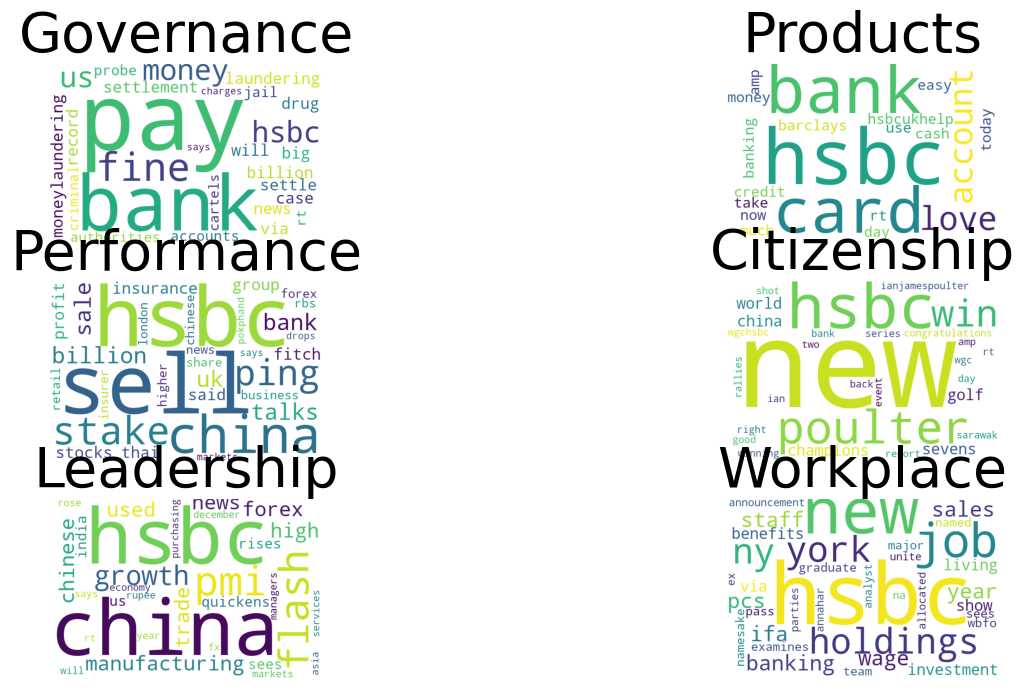

In [8]:
topn = 50
count_array = vectors_count.toarray()
df_feats = pd.DataFrame(data=count_array,columns = count_vectorizer.get_feature_names())


df_g = df_feats[df['dimension']=='Governance'] 
result_g = pd.DataFrame(df_g.mean(), columns = ['value'])
my_feats_g = list(result_g.sort_values(by=['value'], ascending=False)[:topn].index)

df_p = df_feats[df['dimension']=='Products'] 
result_p = pd.DataFrame(df_p.mean(), columns = ['value'])
my_feats_p = list(result_p.sort_values(by=['value'], ascending=False)[:topn].index)

df_pe = df_feats[df['dimension']=='Performance'] 
result_pe = pd.DataFrame(df_pe.mean(), columns = ['value'])
my_feats_pe = list(result_pe.sort_values(by=['value'], ascending=False)[:topn].index)

df_c = df_feats[df['dimension']=='Citizenship'] 
result_c = pd.DataFrame(df_c.mean(), columns = ['value'])
my_feats_c = list(result_c.sort_values(by=['value'], ascending=False)[:topn].index)

df_l = df_feats[df['dimension']=='Leadership'] 
result_l = pd.DataFrame(df_l.mean(), columns = ['value'])
my_feats_l = list(result_l.sort_values(by=['value'], ascending=False)[:topn].index)

df_w = df_feats[df['dimension']=='Workplace'] 
result_w = pd.DataFrame(df_w.mean(), columns = ['value'])
my_feats_w = list(result_w.sort_values(by=['value'], ascending=False)[:topn].index)


fig, ax = plt.subplots(3, 2, figsize=[16, 8])

wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(my_feats_g))
ax[0,0].imshow(wordcloud1)
ax[0,0].axis('off')
ax[0,0].set_title('Governance',fontsize=40);


wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(my_feats_p))

ax[0,1].imshow(wordcloud2)
ax[0,1].axis('off')
ax[0,1].set_title('Products',fontsize=40);

wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(my_feats_pe))
ax[1,0].imshow(wordcloud1)
ax[1,0].axis('off')
ax[1,0].set_title('Performance',fontsize=40);


wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(my_feats_c))

ax[1,1].imshow(wordcloud2)
ax[1,1].axis('off')
ax[1,1].set_title('Citizenship',fontsize=40);

wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(my_feats_l))
ax[2,0].imshow(wordcloud1)
ax[2,0].axis('off')
ax[2,0].set_title('Leadership',fontsize=40);


wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(my_feats_w))

ax[2,1].imshow(wordcloud2)
ax[2,1].axis('off')
ax[2,1].set_title('Workplace',fontsize=40);


plt.show()


# Classification

# First test NB on different feature vectors

In [9]:
my_feats = [vectors_count, vectors_count_stopwords, vectors_count_filtered, 
            vectors_count_bigram, vectors_count_binary, vectors_count_maxfeats, 
            vectors_tfidf, vectors_tfidf_stopwords, vectors_tfidf_maxdf, 
            vectors_tfidf_ngram, vectors_tfidf_binary, vectors_tfidf_maxfeats]

my_outputs = ['Count Vectorizer default', 'Count Vectorizer stopwords', 'Count Vectorizer filtered',
             'Count Vectorizer bigram', 'Count Vectorizer binary', 'Count Vectorizer  Maxfeats',
             'TfIdf default', 'TfIdf stopwords', 'TfIdf maxdf', 'TfIdf ngram', 'TfIdf binary', 'TfIdf maxfeats']

for feat_vector, my_output in zip(my_feats, my_outputs):

    X_train, X_test, y_train, y_test = train_test_split(feat_vector, df["dimension"],
                                                    test_size=0.33, random_state=42)
    
    NB_Vec = MultinomialNB()
    NB_Vec.fit(X_train, y_train)
    y_predict = NB_Vec.predict(X_test)
#     cm = confusion_matrix(y_test, y_predict)
    ascore = f1_score(y_test, y_predict, average = 'weighted')
    print(my_output, ascore)


Count Vectorizer default 0.785257175835105
Count Vectorizer stopwords 0.7790815193610114
Count Vectorizer filtered 0.7751088402836546
Count Vectorizer bigram 0.810950828345346
Count Vectorizer binary 0.7982387737828122
Count Vectorizer  Maxfeats 0.6983497624960632
TfIdf default 0.5100167639878038
TfIdf stopwords 0.5473887760863585
TfIdf maxdf 0.6067259268000373
TfIdf ngram 0.5098492794806967
TfIdf binary 0.5161333984653275
TfIdf maxfeats 0.5560408322526468


# Optimize SVM

In [11]:

X_train, X_test, y_train, y_test = train_test_split(vectors_count_bigram, df["dimension"],
                                                    test_size=0.33, random_state=42)

# Set the parameters by cross-validation
tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
]

scores = ["precision", "recall"]

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_["mean_test_score"]
    stds = clf.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()
    


# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}

Grid scores on development set:

0.633 (+/-0.008) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.633 (+/-0.008) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.687 (+/-0.021) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.633 (+/-0.008) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.760 (+/-0.037) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.688 (+/-0.021) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.758 (+/-0.036) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.764 (+/-0.032) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.763 (+/-0.030) for {'C': 1, 'kernel': 'linear'}
0.763 (+/-0.030) for {'C': 10, 'kernel': 'linear'}
0.763 (+/-0.030) for {'C': 100, 'kernel': 'linear'}
0.763 (+/-0.030) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are compute

C:\Users\ArifogluD\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters set found on development set:

{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}

Grid scores on development set:

0.633 (+/-0.008) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.633 (+/-0.008) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.687 (+/-0.021) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.633 (+/-0.008) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.760 (+/-0.037) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.688 (+/-0.021) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.758 (+/-0.036) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.764 (+/-0.032) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.763 (+/-0.030) for {'C': 1, 'kernel': 'linear'}
0.763 (+/-0.030) for {'C': 10, 'kernel': 'linear'}
0.763 (+/-0.030) for {'C': 100, 'kernel': 'linear'}
0.763 (+/-0.030) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

          

C:\Users\ArifogluD\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Test on different classifiers

In [13]:

print('F-scores with different classifiers ')
    
clf_nb = MultinomialNB().fit(X_train, y_train)
ascore = f1_score(y_test, clf_nb.predict(X_test), average = 'weighted')
print('Naive Bayes', ascore)


clf_lr = LogisticRegression(random_state=0).fit(X_train, y_train)
ascore = f1_score(y_test, clf_lr.predict(X_test), average = 'weighted')
print('Logistic Regression', ascore)

    
clf_svm = SVC(kernel='linear', C=1).fit(X_train, y_train)
ascore = f1_score(y_test, clf_svm.predict(X_test), average = 'weighted')
print('Support Vector Machine', ascore)

clf_dt = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
ascore = f1_score(y_test, clf_dt.predict(X_test), average = 'weighted')
print('Decision Tree', ascore)

clf_neigh = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
ascore = f1_score(y_test, clf_neigh.predict(X_test), average = 'weighted')
print('K-NN', ascore)

from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(max_depth=2, random_state=0).fit(X_train, y_train)
ascore = f1_score(y_test, clf_rf.predict(X_test), average = 'weighted')
print('Random Forest', ascore)



F-scores with different classifiers 
Naive Bayes 0.810950828345346
Logistic Regression 0.7361134281924463
Support Vector Machine 0.7471711730646813
Decision Tree 0.7382347458309398
K-NN 0.5401137399348198
Random Forest 0.4895844694077871


# Hugging Face Sentence Embeddings

In [235]:
data = list(df['tweet_text'].values)

# define the document embedding models to use for comparison
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model_use = hub.load(module_url)
model_st1 = SentenceTransformer('all-mpnet-base-v2')
model_st2 = SentenceTransformer('all-MiniLM-L6-v2')
model_st3 = SentenceTransformer('paraphrase-mpnet-base-v2')

def embed(model, model_type, sentences):
    embeddings = model.encode(sentences)
    return embeddings

# generate embeddings for each model
embeddings_st1 = embed(model_st1, 'sentence transformer', data)
embeddings_st2 = embed(model_st2, 'sentence transformer', data)
embeddings_st3 = embed(model_st3, 'sentence transformer', data)

INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 860.00MB
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder/4, Total size: 987.47MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.


# Let's compare the performance of various sentence embeddings and Count Vectorizer bigram

In [132]:
indices = np.arange(len(embeddings_st1))

(   data_train,
    data_test,
    labels_train,
    labels_test,
    indices_train,
    indices_test,
) = train_test_split(vectors_count_bigram, df['dimension'], indices, test_size=0.33, random_state= 42)


print('F-score with Count Vectorizer bigram ')    
clf_svm = SVC(kernel='linear', C=1).fit(data_train, y_train)
ascore = f1_score(y_test, clf_svm.predict(data_test), average = 'weighted')
print(ascore)

print('F-score with  sentence embedding1 ')    
clf_svm = SVC(kernel='linear', C=1).fit(embeddings_st1[indices_train], y_train)
ascore = f1_score(y_test, clf_svm.predict(embeddings_st1[indices_test]), average = 'weighted')
print(ascore)


print('F-score with  sentence embedding2 ')    
clf_svm = SVC(kernel='linear', C=1).fit(embeddings_st2[indices_train], y_train)
ascore = f1_score(y_test, clf_svm.predict(embeddings_st2[indices_test]), average = 'weighted')
print(ascore)

print('F-score with sentence embedding3 ')    
clf_svm = SVC(kernel='linear', C=1).fit(embeddings_st3[indices_train], y_train)
ascore = f1_score(y_test, clf_svm.predict(embeddings_st3[indices_test]), average = 'weighted')
print(ascore)



F-score with Count Vectorizer bigram 
0.7471711730646813
F-score with  sentence embedding1 
0.8503506122646597
F-score with  sentence embedding2 
0.8412923918849916
F-score with sentence embedding3 
0.8720628525450181


# Label Propagation

In [161]:

rnd = np.random.RandomState(42)

df['dimension'] = pd.Categorical(pd.factorize(df['dimension'])[0])


# Randomly unlabel some records in the dataset
#unlabeled points are marked as -1
random_unlabeled_points = rnd.rand(len(df['dimension'])) < 0.6
labels = np.copy(df['dimension'])
labels_orig = np.copy(df['dimension'])
labels[random_unlabeled_points] = -1
X=embeddings_st3
tot_unlabled=labels[labels==-1]
print(f"Total Records in dataset is {len(X)} and unlabeled records is  {len(tot_unlabled)}")

# define model
model = LabelPropagation(kernel='knn',n_neighbors=10, gamma=30, max_iter=2000)
# fit model on training dataset
model.fit(X, labels)
# make predictions
predicted_labels = model.predict(X[random_unlabeled_points])
true_labels = labels_orig[random_unlabeled_points]

#print the classification report and confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=model.classes_)
print("Label propagation model: %d labeled & %d unlabeled points (%d total)" %
      (len(labels[labels!=-1]), len(tot_unlabled) , len(X)))

print(classification_report(true_labels, predicted_labels))
print("Confusion matrix")
print(cm)

Total Records in dataset is 963 and unlabeled records is  588
Label propagation model: 375 labeled & 588 unlabeled points (963 total)
              precision    recall  f1-score   support

           0       0.09      0.97      0.16        40
           1       1.00      0.33      0.50       375
           2       0.00      0.00      0.00        13
           3       0.91      0.29      0.44        34
           4       0.00      0.00      0.00        43
           5       0.00      0.00      0.00        47
           6       1.00      0.44      0.62        36

    accuracy                           0.32       588
   macro avg       0.43      0.29      0.25       588
weighted avg       0.76      0.32      0.39       588

Confusion matrix
[[ 39   0   0   1   0   0   0]
 [251 124   0   0   0   0   0]
 [ 13   0   0   0   0   0   0]
 [ 24   0   0  10   0   0   0]
 [ 43   0   0   0   0   0   0]
 [ 47   0   0   0   0   0   0]
 [ 20   0   0   0   0   0  16]]


# Sentence embeddings and cosine similarity

In [279]:
# Let's use embeddings_st2
cos_sim = cosine_similarity(
    embeddings_st2,
    embeddings_st2
)

# the bigger cosine sim is better
# this sorts in ascending order, so take last n
#cos_sim.sort()

cos_sim_arg = cos_sim.argsort()

topn = 20 
topn_sum = 0

# see how many of dimensions in topn are same as the query dimension
for j in range(0, len(df)):
    
    query_dimension = df.iloc[1]['dimension']
    
    match = df.iloc[cos_sim_arg[j,-topn:]]['dimension'].value_counts()[query_dimension]
    
    # how many of top-n instances have the same dimension as the query
    topn_sum =+ match/topn


print(topn_sum/len(df))


0.00031152647975077883


# Sentence embeddings and jaccard similarity

In [280]:
def jaccard_sim(str1, str2): 
    a = set(str1.split()) 
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

a = df['tweet_text'].str.split()
b = a.apply(lambda x: set(x))

js = np.zeros((len(df), len(df)))

for i in range(0, len(df)):
    for j in range(0, len(df)):
        js[i, j] = jaccard_sim(df['tweet_text'].iloc[i], df['tweet_text'].iloc[j])
        
cos_sim_arg = js.argsort()

topn = 20
topn_sum = 0

# see how many of dimensions in topn are same as the query dimension
for j in range(0, len(df)):
    
    query_dimension = df.iloc[1]['dimension']
    
    match = df.iloc[cos_sim_arg[j,-topn:]]['dimension'].value_counts()[query_dimension]
    
    topn_sum =+ match/topn

print(topn_sum/len(df))


0.00025960539979231567
